In [1]:
import os
import random
import time
import datetime
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from utils import seeding, create_dir, print_and_save, shuffling, epoch_time, calculate_metrics
from model import build_resunetplusplus
from metrics import DiceLoss, DiceBCELoss
import visdom


In [2]:

# Set up Visdom for plotting
vis = visdom.Visdom()
vis.env = 'training'
vis.line(
    X=np.array([0]), Y=np.array([0]), win='train_loss', opts=dict(title='Training Loss', xlabel='Epochs', ylabel='Loss')
)
vis.line(
    X=np.array([0]), Y=np.array([0]), win='val_loss', opts=dict(title='Validation Loss', xlabel='Epochs', ylabel='Loss')
)


Setting up a new session...
Traceback (most recent call last):
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py", line 495, in _make_request
    conn.r

Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/home/zitongc/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py", line 495, in _make_request
    conn.request(
  File "/home/zitong

False

In [3]:
def load_data(path):
    # Define the paths for images and masks
    image_files = sorted(glob(os.path.join(path, "*.tif")))
    mask_files = sorted(glob(os.path.join(path, "*.png")))

    # Find common files based on the basename (without extension)
    image_basenames = [os.path.basename(f).split('_')[0] for f in image_files]
    mask_basenames = [os.path.basename(f).split('.')[0] for f in mask_files]

    # Only keep images with corresponding masks
    common_files = set(image_basenames).intersection(mask_basenames)
    
    train_x, train_y = [], []
    
    for basename in common_files:
        image_path = os.path.join(path, f"{basename}_2019_07.tif")
        mask_path = os.path.join(path, f"{basename}.png")
        if os.path.exists(image_path) and os.path.exists(mask_path):
            train_x.append(image_path)
            train_y.append(mask_path)
    
    # Split the dataset into training and validation sets
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
    
    # Further split validation data to create a test set (e.g., 10% of the data for testing)
    valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=42)

    return [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]

class DATASET(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.size = size
        self.transform = transform
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Image """
        image_bgr= cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        image = cv2.resize(image, self.size)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0

        mask = cv2.resize(mask, self.size)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0

        return image, mask

    def __len__(self):
        return self.n_samples


In [ ]:
#Updated binary mask

In [22]:
codes_to_keep = list(range(1, 10)) + [11, 14, 15, 16, 17, 18, 19, 21, 24, 25, 26, 28]

def load_data(path):
    # Define the paths for images and masks
    image_files = sorted(glob(os.path.join(path, "*.tif")))
    mask_files = sorted(glob(os.path.join(path, "*.png")))

    # Find common files based on the basename (without extension)
    image_basenames = [os.path.basename(f).split('_')[0] for f in image_files]
    mask_basenames = [os.path.basename(f).split('.')[0] for f in mask_files]

    # Only keep images with corresponding masks
    common_files = set(image_basenames).intersection(mask_basenames)
    
    train_x, train_y = [], []
    
    for basename in common_files:
        image_path = os.path.join(path, f"{basename}_2019_07.tif")
        mask_path = os.path.join(path, f"{basename}.png")
        if os.path.exists(image_path) and os.path.exists(mask_path):
            train_x.append(image_path)
            train_y.append(mask_path)
    
    # Split the dataset into training and validation sets
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
    
    # Further split validation data to create a test set (e.g., 10% of the data for testing)
    valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=42)

    return [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]

class DATASET(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.size = size
        self.transform = transform
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Image """
        # Load the image
        image_bgr = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Load the multi-class mask
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        # Convert multi-class mask to binary mask based on `codes_to_keep`
        binary_mask = np.isin(mask, codes_to_keep).astype(np.uint8)

        # Resize image and mask
        image = cv2.resize(image, self.size)  # Resize to desired size
        binary_mask = cv2.resize(binary_mask, self.size)  # Resize mask to match image

        if self.transform is not None:
            # Apply transformations
            augmentations = self.transform(image=image, mask=binary_mask)
            image = augmentations["image"]
            binary_mask = augmentations["mask"]

        # Normalize image
        image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W) format
        image = image / 255.0  # Normalize image

        # Add channel dimension to the binary mask
        binary_mask = np.expand_dims(binary_mask, axis=0)

        return image, binary_mask

    def __len__(self):
        return self.n_samples


In [23]:
def train(model, loader, optimizer, loss_fn, device):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, (x, y) in enumerate(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        y_pred = torch.sigmoid(y_pred)
        for yt, yp in zip(y, y_pred):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

def evaluate(model, loader, loss_fn, device):
    model.eval()

    epoch_loss = 0
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            y_pred = torch.sigmoid(y_pred)
            for yt, yp in zip(y, y_pred):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

        epoch_loss = epoch_loss/len(loader)
        epoch_jac = epoch_jac/len(loader)
        epoch_f1 = epoch_f1/len(loader)
        epoch_recall = epoch_recall/len(loader)
        epoch_precision = epoch_precision/len(loader)

        return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]


In [24]:
# Seeding
seeding(42)

# Directories
create_dir("files")

# Hyperparameters
image_size = 256
size = (image_size, image_size)
batch_size = 16
num_epochs = 500
lr = 1e-4
early_stopping_patience = 50
checkpoint_path = "../files/checkpoint.pth"
path = "../../dataset/2x_downsample"

# Dataset loading
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
train_x, train_y = shuffling(train_x, train_y)

# Dataset and loader
transform = A.Compose([
    A.Rotate(limit=35, p=0.3),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
])

train_dataset = DATASET(train_x, train_y, size, transform=transform)
valid_dataset = DATASET(valid_x, valid_y, size, transform=None)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_resunetplusplus()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
loss_fn = DiceBCELoss()


In [25]:
def train(model, loader, optimizer, loss_fn, device, valid_dataset):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    num_batches = len(loader)  # Total number of batches in the loader

    for i, (x, y) in enumerate(loader):
        start_time = time.time()  # Start timing the batch

        # Transfer data to the GPU (if available)
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x)
        
        # Calculate loss
        loss = loss_fn(y_pred, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update total loss
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        y_pred = torch.sigmoid(y_pred)
        for yt, yp in zip(y, y_pred):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

        # End timing the batch
        end_time = time.time()
        batch_time = end_time - start_time

        # Print progress and time for the current batch
        print(f"Batch {i+1}/{num_batches} - Loss: {loss.item():.4f} - Time: {batch_time:.2f}s")

        # Call random_image_prediction every 30 batches
        if (i + 1) % 30 == 0:
            print(f"Visualizing prediction after batch {i+1}")
            random_image_prediction(model, valid_dataset, device)

    # Normalize the metrics by the number of batches
    epoch_loss = epoch_loss / num_batches
    epoch_jac = epoch_jac / num_batches
    epoch_f1 = epoch_f1 / num_batches
    epoch_recall = epoch_recall / num_batches
    epoch_precision = epoch_precision / num_batches

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]


In [26]:
import random
import matplotlib.pyplot as plt

def random_image_prediction(model, dataset, device):
    """ Select a random image from the dataset, predict its mask, and visualize it with the original and true mask. """
    
    # Set the model to evaluation mode
    model.eval()

    # Randomly choose a sample from the dataset
    random_idx = random.randint(0, len(dataset) - 1)
    original_image, true_mask = dataset[random_idx]  # Get the image and true mask
    
    # Add batch dimension to the image (as the model expects a batch)
    image_tensor = torch.tensor([original_image], dtype=torch.float32).to(device)

    # Get the model prediction
    with torch.no_grad():
        pred_mask = model(image_tensor)
    
    # Apply sigmoid to get the probability mask without thresholding (continuous values)
    pred_mask = torch.sigmoid(pred_mask).cpu().numpy()[0][0]  # [0][0] to remove batch and channel dimensions
    
    # Remove batch and channel dimensions for original and true mask
    original_image = original_image.transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    true_mask = true_mask[0]  # True mask (H, W)
    
    # Plot the results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("True Mask")
    axs[1].axis('off')
    
    axs[2].imshow(pred_mask, cmap='gray')  # Display the predicted mask as a heatmap (no thresholding)
    axs[2].set_title("Predicted Mask (Heatmap)")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [27]:
# binary mask random visualization

In [34]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

# The list of codes that correspond to the relevant crop classes
codes_to_keep = list(range(1, 10)) + [11, 14, 15, 16, 17, 18, 19, 21, 24, 25, 26, 28]

def random_image_prediction(model, dataset, device):
    """ Select a random image from the dataset, predict its mask, and visualize it with the original, true, heatmap, and binary prediction. """
    
    # Set the model to evaluation mode
    model.eval()

    # Randomly choose a sample from the dataset
    random_idx = random.randint(0, len(dataset) - 1)
    original_image, true_mask = dataset[random_idx]  # Get the image and true mask

    # Move the original image to the model's device (the image is already a tensor from the dataset)
    image_tensor = torch.tensor([original_image], dtype=torch.float32).to(device)

    # Get the model prediction
    with torch.no_grad():
        pred_mask = model(image_tensor)
    
    # Apply sigmoid to get the probability mask without thresholding (continuous values)
    pred_mask = torch.sigmoid(pred_mask).cpu().numpy()[0][0]  # [0][0] to remove batch and channel dimensions

    # Create a binary mask from the predicted mask (threshold at 0.5)
    binary_pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Convert the true mask to binary (based on the relevant crop classes in `codes_to_keep`)
    binary_mask = true_mask[0]  # The true mask should already be binary

    # Remove batch and channel dimensions for original image (true mask is already 2D)
    original_image = original_image.transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    
    # Plot the results
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(binary_mask, cmap='gray')  # Display the binary mask (0 or 1)
    axs[1].set_title("True Binary Mask (0: Not Field, 1: Field)")
    axs[1].axis('off')

    axs[2].imshow(pred_mask, cmap='gray')  # Display the predicted mask as a heatmap (no thresholding)
    axs[2].set_title("Predicted Mask (Heatmap)")
    axs[2].axis('off')

    axs[3].imshow(binary_pred_mask, cmap='gray')  # Display the predicted binary mask
    axs[3].set_title("Predicted Binary Mask (0: Not Field, 1: Field)")
    axs[3].axis('off')
    
    plt.tight_layout()
    plt.show()


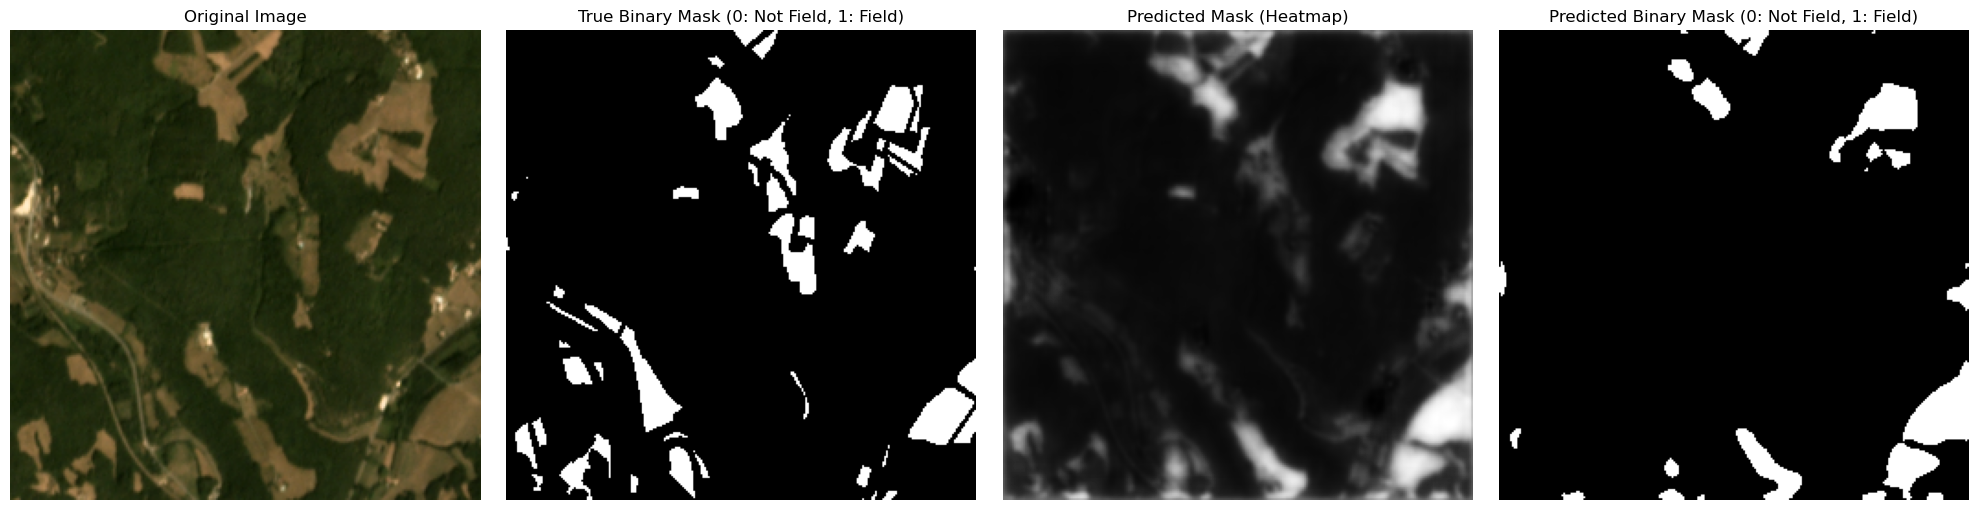

In [35]:
# After training, you can call the function like this:

random_image_prediction(model, valid_dataset, device)

In [ ]:

# Initialize Visdom
vis = visdom.Visdom()

# Create windows for training and validation loss
vis_train_loss = vis.line(X=np.array([0]), Y=np.array([0]), win='train_loss', opts=dict(title='Training Loss', xlabel='Epochs', ylabel='Loss'))
vis_val_loss = vis.line(X=np.array([0]), Y=np.array([0]), win='val_loss', opts=dict(title='Validation Loss', xlabel='Epochs', ylabel='Loss'))

best_valid_metrics = float("-inf")

for epoch in range(num_epochs):
    start_time = time.time()

    # Train for one epoch
    train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device, valid_dataset)

    # Evaluate after the epoch
    valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
    scheduler.step(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Update Visdom plot for training and validation loss
    vis.line(X=np.array([epoch+1]), Y=np.array([train_loss]), win=vis_train_loss, update='append')
    vis.line(X=np.array([epoch+1]), Y=np.array([valid_loss]), win=vis_val_loss, update='append')

    # Save model if validation metrics improved
    if valid_metrics[1] > best_valid_metrics:
        best_valid_metrics = valid_metrics[1]
        torch.save(model.state_dict(), checkpoint_path)
        early_stopping_count = 0
    else:
        early_stopping_count += 1

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch Time: {epoch_mins}m {epoch_secs}s")

    # Early stopping
    if early_stopping_count == early_stopping_patience:
        print("Early stopping")
        break


Setting up a new session...


Batch 1/494 - Loss: 0.8545 - Time: 1.34s
Batch 2/494 - Loss: 0.8513 - Time: 1.24s
Batch 3/494 - Loss: 0.9420 - Time: 1.24s
Batch 4/494 - Loss: 0.9569 - Time: 1.22s
Batch 5/494 - Loss: 0.8278 - Time: 1.23s
Batch 6/494 - Loss: 0.9574 - Time: 1.25s
Batch 7/494 - Loss: 0.8746 - Time: 1.23s
Batch 8/494 - Loss: 0.8556 - Time: 1.24s
Batch 9/494 - Loss: 0.9174 - Time: 1.28s
Batch 10/494 - Loss: 0.9373 - Time: 1.25s
Batch 11/494 - Loss: 0.8817 - Time: 1.26s
Batch 12/494 - Loss: 0.8031 - Time: 1.27s
Batch 13/494 - Loss: 0.8747 - Time: 1.25s
Batch 14/494 - Loss: 0.8708 - Time: 1.26s


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(images, true_masks, predicted_masks, num_samples=3):
    """ Function to visualize the original images, true masks, and predicted masks """
    # Ensure we are working with the same number of samples
    num_samples = min(num_samples, len(images))
    
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    if num_samples == 1:  # If we only have one sample, make axs a 2D array
        axs = np.expand_dims(axs, axis=0)

    for i in range(num_samples):
        img = images[i].transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
        true_mask = true_masks[i][0]         # Remove channel dimension for mask
        pred_mask = predicted_masks[i][0]    # Predicted mask
        
        axs[i, 0].imshow(img)
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(true_mask, cmap='gray')
        axs[i, 1].set_title("True Mask")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
##Back up code

In [ ]:
import random

def evaluate(model, loader, loss_fn, device, visualize_samples=False):
    model.eval()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    original_images = []
    true_masks = []
    predicted_masks = []

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            # Model prediction
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            # Sigmoid to get predictions in the range [0, 1]
            y_pred = torch.sigmoid(y_pred)

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            for yt, yp in zip(y, y_pred):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

            # Collect some samples for visualization if needed
            if visualize_samples:
                original_images.extend(x.cpu().numpy())
                true_masks.extend(y.cpu().numpy())
                predicted_masks.extend((y_pred.cpu().numpy() > 0.5).astype(np.uint8))  # Threshold to get binary mask

    # Normalize the metrics
    epoch_loss /= len(loader)
    epoch_jac /= len(loader)
    epoch_f1 /= len(loader)
    epoch_recall /= len(loader)
    epoch_precision /= len(loader)

    # Visualize a few sample predictions
    if visualize_samples:
        sample_indices = random.sample(range(len(original_images)), min(3, len(original_images)))
        visualize_predictions(
            [original_images[i] for i in sample_indices],
            [true_masks[i] for


In [ ]:
best_valid_metrics = 0.0
early_stopping_count = 0

for epoch in range(num_epochs):
    start_time = time.time()

    # Train for one epoch
    train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)

    # Evaluate and visualize predictions every few epochs
    visualize_samples = (epoch % 5 == 0)  # Set to True every 5 epochs
    valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device, visualize_samples=visualize_samples)
    scheduler.step(valid_loss)

    # Print epoch-level results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Update Visdom plot for training and validation loss
    vis.line(X=np.array([epoch+1]), Y=np.array([train_loss]), win='train_loss', update='append')
    vis.line(X=np.array([epoch+1]), Y=np.array([valid_loss]), win='val_loss', update='append')

    # Save model if validation metrics improved
    if valid_metrics[1] > best_valid_metrics:
        best_valid_metrics = valid_metrics[1]
        torch.save(model.state_dict(), checkpoint_path)
        early_stopping_count = 0
    else:
        early_stopping_count += 1

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch Time: {epoch_mins}m {epoch_secs}s")

    # Early stopping
    if early_stopping_count == early_stopping_patience:
        print("Early stopping")
        break
